# Handin 2: OCR with SVM and (Deep) Neural Nets 
In this handin, you will build more classifiers for optical character
recognition (OCR).  The main exercise is building a classifier for the
AuDigits data set consisting of digits that you drew in class.
The goal is simply to do as well as possible on the unknown images we have kept secret, and of
course to tell the customer (me) how well your classifier will do.

There are three parts to the hand in.
1. Support Vector Machines for OCR on AU Digits
2. Neural Nets using Tensorflow for OCR on AU digits
3. Competition. Making the best OCR AU digits classifier for 2016 ML class


The specific requirements for (1) and (2) are are stated after the description of (2)
and the requirements for (3) are stated after the description of (3).

The last part of this assignment is very open, and you
yourself have to figure out where to put the focus.

### Formalities
** You must upload a PDF report that is organized as a report **.
We do not want to read comments between lines of python code inside the exercise description!.

You can write your report in Danish if you prefer.
The maximal report length is 5 pages.
You are allowed to be up to 3 members in a group.
You are encouraged to discuss the exercise between groups and help
each other as much as possible without of course copying each others work.
Particularly, discussing the quality of your classifiers is a
good idea to get an indication if you are doing it
correctly.
Questions are always welcome on the BlackBoard discussion board.
Be to actually formulate a precise question of what the issue is.
In your report, you should discuss all the choices you have made in your implementation,
and explain why your think the quality of your classifier is as it is.
Upload your report in a PDF file and your code
(for the great classifier you have made) in a separate ZIP file.
The format for that code is described after part (3).




### Important Remarks
This handin will probably require more code than the first, the Tensorflow system you must use for neural nets is not completely trivial, and the experiments you must run  will **take quite some time**.
So start early!

# The data
There are two data sets. The famous MNIST-Digits data set is a classic machine learning data set, and the AU-Digits data set generated by you and your predecessor Machine Learning students. Each data set is split in two: the training and the test set.

We released the AU Digits data set on September 8 2016, so that is what we focus on for now.
As states above there is a hidden data set only known to us which is where your will face as their final test!.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_file = np.load('auTrain.npz')
print(train_file.keys())  # ['digits', 'labels']
images = train_file['digits']
labels = train_file['labels']
print('Shape of input data: %s' % (images.shape,))
print('Shape of input labels: %s' % (labels.shape,))

['digits', 'labels']
Shape of input data: (10380, 784)
Shape of input labels: (10380,)


In [3]:
test_file = np.load('auTest.npz')
print(test_file.keys())
images_test = test_file['digits']
labels_test = test_file['labels']
print('Shape of test input data: %s' % (images_test.shape,))

['digits', 'labels']
Shape of test input data: (2580, 784)


## Support Vector Machines

The first thing you must try is Support Vector Machines.
An implemetation is available in the *sklearn* package.
There is excellent example code in the documentation:
http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
For for show lets us apply a linear SVM and see the result and a Support Vector.


(8025, 784)


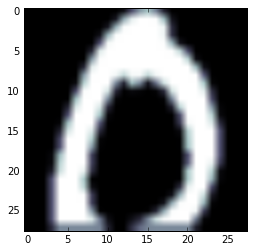

In [4]:
from sklearn import svm
clf = svm.SVC(kernel='poly',C=1)
clf.fit(images, labels)
print(clf.support_vectors_.shape)
plt.imshow(clf.support_vectors_[0].reshape(28,-1),cmap='bone')
   

Let's see how well it does.

In [6]:
in_sample_accuracy = (clf.predict(images)==labels).mean()
print('In sample Accuracy {:.2%}, In Sample Error {:.4f} '.format(in_sample_accuracy,1-in_sample_accuracy))
out_of_sample_accuracy = (clf.predict(images_test)==labels_test).mean()
print('Out of sample Accuracy {:.2%}, In Sample Error {:.4f}'.format(out_of_sample_accuracy,1-out_of_sample_accuracy))

In sample Accuracy 83.57%, In Sample Error 0.1643 
Out of sample Accuracy 81.67%, In Sample Error 0.1833


Does not seem to bad, albeit it is seemingly overfitting.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import svm
import numpy as np
import datetime

def CV_SVM(X_train,y_train, X_test, y_test, param, scoring):
    model = GridSearchCV(svm.SVC(C=1), param, cv = 5, scoring = scoring)
    model.fit(X_train, y_train)
    
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, model.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    
    
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))
    
    return(model.best_params_)

def linear_iterative_optimization(X_train, y_train, X_test, y_test, scoring, init_param, n_iter = 6):
    kernel = 'linear'
    scoring = scoring
    param = init_param

    for i in range(n_iter):
        print("tid ",datetime.datetime.now().time())
        args = [{'kernel' : [kernel], 'C' : param}]
        model = GridSearchCV(svm.SVC(C=1), args, cv = 5, scoring = scoring)
        model.fit(X_train, y_train)
        means = model.cv_results_['mean_test_score']
        stds = model.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, model.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        y_true, y_pred = y_test, model.predict(X_test)
        report = classification_report(y_true, y_pred)
        print(report)
        best_params = model.best_params_
        best_index = np.where(param==best_params['C'])[0]
        if best_index == (len(param)-1):
            param = np.logspace(np.log10(param[best_index-1]), np.log10(param[best_index]*2), num = 6)
        else:    
            if best_index == 0:
                param = np.logspace(np.log10(param[best_index]/10), np.log10(param[best_index+1]), num = 6)
            else:  
                param = np.logspace(np.log10(param[best_index-1]), np.log10(param[best_index+1]), num = 6)

    return best_params, report

def gauss_iterative_optimization(X_train, y_train, X_test, y_test, scoring, init_param, n_iter = 6):
    kernel = 'rbf'
    scoring = scoring
    param = init_param

    for i in range(n_iter):
        print("tid ",datetime.datetime.now().time())
        args = [{'kernel' : [kernel], 'C' : param['C'],'gamma':param['gamma']}]
        model = GridSearchCV(svm.SVC(C=1), args, cv = 5, scoring = scoring)
        model.fit(X_train, y_train)
        means = model.cv_results_['mean_test_score']
        stds = model.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, model.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        y_true, y_pred = y_test, model.predict(X_test)
        report = classification_report(y_true, y_pred)
        print(report)
        best_params = model.best_params_
        print("best params ",best_params)
        best_index_C = np.where(param['C']==best_params['C'])[0]
        best_index_gamma=np.where(param['gamma']==best_params['gamma'])[0]
        if best_index_C == (len(param['C'])-1):
            param['C'] = np.logspace(np.log10(param['C'][best_index_C-1]), np.log10(param['C'][best_index_C]*2), num = 5)
        else:
            if best_index_C == 0:
                param['C'] = np.logspace(np.log10(param['C'][best_index_C]/10), np.log10(param['C'][best_index_C+1]), num = 5)
            else:  
                param['C'] = np.logspace(np.log10(param['C'][best_index_C-1]), np.log10(param['C'][best_index_C+1]), num = 5)
        if best_index_gamma == (len(param['gamma'])-1):
            param['gamma'] = np.logspace(np.log10(param['gamma'][best_index_gamma-1]), np.log10(param['gamma'][best_index_gamma]*2), num = 5)
        else:
            if best_index_gamma == 0:
                param['gamma'] = np.logspace(np.log10(param['gamma'][best_index_gamma]/10), np.log10(param['gamma'][best_index_gamma+1]), num = 3)
            else:  
                param['gamma'] = np.logspace(np.log10(param['gamma'][best_index_gamma-1]), np.log10(param['gamma'][best_index_gamma+1]), num = 3)

    return best_params, report

def polynomial_iterative_optimization(X_train, y_train, X_test, y_test, scoring, init_param, n_iter = 6):
    kernel = 'poly'
    scoring = scoring
    param = init_param

    for i in range(n_iter):
        print("tid ",datetime.datetime.now().time())
        args = [{'kernel' : [kernel], 'C' : param['C'],'degree':param['degree']}]
        model = GridSearchCV(svm.SVC(C=1), args, cv = 5, scoring = scoring)
        model.fit(X_train, y_train)
        means = model.cv_results_['mean_test_score']
        stds = model.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, model.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
        y_true, y_pred = y_test, model.predict(X_test)
        report = classification_report(y_true, y_pred)
        print(report)
        best_params = model.best_params_
        print("best params ",best_params)
        best_index_C = np.where(param['C']==best_params['C'])[0]
        best_index_degree=np.where(param['degree']==best_params['degree'])[0]
        if best_index_C == (len(param['C'])-1):
            param['C'] = np.logspace(np.log10(param['C'][best_index_C-1]), np.log10(param['C'][best_index_C]*2), num = 3)
        else:
            if best_index_C == 0:
                param['C'] = np.logspace(np.log10(param['C'][best_index_C]/10), np.log10(param['C'][best_index_C+1]), num = 3)
            else:  
                param['C'] = np.logspace(np.log10(param['C'][best_index_C-1]), np.log10(param['C'][best_index_C+1]), num = 3)
        if best_index_degree == (len(param['degree'])-1):
            param['degree'] = np.linspace(param['degree'][best_index_degree-1],param['degree'][best_index_gamma]*2, num = 3)
        else:
            if best_index_degree == 0:
                param['degree'] = np.linspace(param['degree'][best_index_degree]/10,param['degree'][best_index_degree+1], num = 3)
            else:  
                param['degree'] = np.linspace(param['degree'][best_index_degree-1], param['degree'][best_index_degree+1], num = 3)

    return best_params, report

def main():
    train_file = np.load('auTrain.npz')
    X_train = train_file['digits']
    y_train = train_file['labels']
    
    test_file = np.load('auTest.npz')
    X_test = test_file['digits']
    y_test = test_file['labels']
    
    #test linear kernel
    #print(CV_SVM(X_train, y_train, X_test, y_test, [{'kernel' : ['linear'], 'C': [0.1, 1]}],
    #             scoring = 'precision_macro'))
                
    #print(linear_iterative_optimization(X_train, y_train, X_test, y_test,
    #                                    'precision_macro', np.logspace(-1,1, num = 6), 7))

    #print(gauss_iterative_optimization(X_train, y_train, X_test, y_test,
    #                                    'precision_macro', {'C':np.logspace(-2,3, num = 5),'gamma':np.logspace(-5,-2, num = 3)}, 6))
    print(polynomial_iterative_optimization(X_train, y_train, X_test, y_test, 'precision_macro', {'C':np.logspace(-2,3, num = 3),'degree':[1,2,3]}, n_iter = 2))
if __name__ == '__main__':
    main()

tid  11:01:05.863312
0.787 (+/-0.009) for {'C': 0.01, 'degree': 1, 'kernel': 'poly'}
0.764 (+/-0.013) for {'C': 0.01, 'degree': 2, 'kernel': 'poly'}
0.751 (+/-0.026) for {'C': 0.01, 'degree': 3, 'kernel': 'poly'}
0.920 (+/-0.003) for {'C': 3.1622776601683795, 'degree': 1, 'kernel': 'poly'}
0.921 (+/-0.002) for {'C': 3.1622776601683795, 'degree': 2, 'kernel': 'poly'}
0.886 (+/-0.011) for {'C': 3.1622776601683795, 'degree': 3, 'kernel': 'poly'}
0.915 (+/-0.006) for {'C': 1000.0, 'degree': 1, 'kernel': 'poly'}
0.958 (+/-0.003) for {'C': 1000.0, 'degree': 2, 'kernel': 'poly'}
0.963 (+/-0.005) for {'C': 1000.0, 'degree': 3, 'kernel': 'poly'}
             precision    recall  f1-score   support

          0       0.98      0.99      0.98       258
          1       0.95      0.98      0.96       258
          2       0.99      0.97      0.98       258
          3       0.93      0.97      0.94       258
          4       0.98      0.95      0.96       258
          5       0.97      0.93    

TypeError: only integer arrays with one element can be converted to an index

In [ ]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [0.1, 1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [0.1, 1, 10, 100, 1000]},
                   {'kernel': ['poly'], 'degree': [1,2,3,5,8,10], 'C': [0.1,1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    clf = GridSearchCV(svm.SVC(C=1), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print(clf.best_params_)


    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()


### Deliverables 
You must write code than can applies SVM using different kernels and different hyperparameters to the digits data and find the best combinatin using validation. 
You must try the following
* Linear Kernel: Use  different values for hyperparamter *C* the cost of being
    on the wrong side of the margin.
* Polynomial Kernel
    Use different polynomial degree $d$ and $C$.
    You must at least try $d = 2$, but higher degrees are of course allowed.
* RBF (Gaussian) Kernel
    Try RBF Kernels with different shape parameter $\gamma$
    ($\lambda$ in the notes), and *C*.


You should use validation and grid search to find the best combination of kernel and parameters for AU digit recognition. The validation set should come from the training data not the test data. Finding (few) hyperparameters is usually done by grid search.
#### Grid Search Validation
For the RBF kernel you need a good *C*
(cost of wrong side of margin) and $\gamma$.
Do this by defining an (exponentially) decreasing list of options for each parameter
and then compute the validation estimate on each combination.
One can do that in multiple iterations to slowly zoom
in on a good value pair.


## Neural Nets
You  must also try to do digit recognition using neural nets, in particular in Googles Open Source Framework, Tensorflow. Read the guide the TA gratiously has provided for you. 

### Deliverables
You must try using a classific neural net with one input layer, one hidden layer, and one output layer.
You can chosse whichever non-linear activation function you want but we suggest using logistic or rectified linear unit (relu).  You must again experiment with the hyperparameters, in particular
network size (hidden layer) and regularization (weight decay, droupout), and use
validation to find the best combination for the digits data. The validation data should come from the training data not the test data.

## Report
In the report, explain what you have done and and provide
tables that show your results. Include tables of your validation
results for all the SVMs and Neural Nets you have tested as well as the out 
of sample error/accuracy computed using the test set for the best SVM and the neural net you have found so far.


## Competition: Making the best classifier in 2016 ML Class

The final exercise is a competiton between all students of this years ML class and then a *standard* solution provided by the TA. You must deliver the best AU digits classifier you can and upload as part of the hand in (
The format is described below). It can be based on both SVM or Neural Nets whichever you get the best results from.

We will evaluate all classifiers we receive on a hidden data set none of you have seen (but it was created by you).
If a classifier takes excessively long time it will be killed and get a score of 0.
The group that has the highest accuracy (lowest error) wins a prize (this could be the TA).

At the last lecture we will show the results of your labor and
declare a winner. As stated the TA also enters the competition with a
baseline classifier, which as stated, you must beat to win the prize, as well of course beating all the other students -- so get creative. Last year's
winner had just shy of 97% correct on last year's data set.
There are more, and potentially more different, data to use this year and this is the first year you are allowed to use the power of automatic differentiation (Tensorflow). So we expect you to do better :)

Below we have provided a few pointers to things you could try. It is really up to you.
The format for uploading your classifier is really simple. It is python3 file that contains a function named `predict` that takes as input a matrix `X` of input images (i.e. a $n \times 784$ matrix where $n$ is the number of test images and 784 is the dimension of the images we consider). The name of the file should be **predict.py** and be sure to test it before you upload. **Remember to upload any additional files next to this file in the ZIP-archive.**

### Example code structure

We recommend that you make a file named `train.py` or similar that saves the best parameters to a file, and then a separate file named `predict.py` that does not do any training, but just loads the parameters and runs prediction.

For instance, if you decide to use SVM as your best classifier, your `train.py` may look like:

In [6]:
# train.py
from sklearn import svm
clf = svm.SVC(kernel='linear',C=1)
clf.fit(images, labels)
np.savez_compressed('myfile.npz',my_model=clf)

Then, your `predict.py` may define the function `predict` as follows:

In [7]:
# predict.py
from sklearn import svm
def predict(input):
    # initialize stuff like your model
    tmp = np.load('myfile.npz')
    my_model = tmp['my_model'].item()  # item because np.savez_compressed saves numpy arrays...
    # predict with your model
    res = my_model.predict(input)
    assert len(res) == input.shape[0]
    # return predictions
    return res

Finally, we will have a secret test file that loads your `predict` function and runs it on the secret test data.
You may imagine our file looks something like:

In [8]:
# secret_evaluation_code.py
def evaluate_student_classifier():
    ten_predictions = predict(images_test[0:13])
    correct = labels_test[0:13]
    assert ten_predictions.shape == correct.shape
    accuracy = np.mean(ten_predictions == correct)
    print("The student gets {:.2%} points".format(accuracy))
evaluate_student_classifier()

The student gets 92.31% points


**If you use Tensorflow**, remember to put your `construct_graph` function (described in the Tensorflow guide) in both `train.py` and `predict.py`, and make sure they are identical so that the `Saver` works in both `train.py` and `predict.py`. Also remember to include the checkpoint file that you load in `predict.py` when you upload to Blackboard.

## Report
After you have done all your experiments you must select what you
think is the best classifier possible. You should create a Python code
file that can evaluate that classifier on an input matrix of images
(that are formatted as the training data). 
If you store your model in a separate *npz*-file (np.savez_compressed) that your code loads,
remember to include this in your ZIP file alongside your code.

Describe the classifier you decide on in the report, give us any additional validation estimates you have used for your decision and give an estimate of how well it will work on the unknown data and a reason for
that estimate (you should use the test data for that).

### Making the Best AU OCR Classifier
Here are some things you can apply to have a better chance of winning
the competition.
### Tensorflow Convolutional Nets
Convolutional Nets are the state of the art in such image recognition scenarios, so we suggest you start there and use Tensorflow for that. The TA's solution closely follows the [Deep MNIST for Experts](https://www.tensorflow.org/versions/r0.11/tutorials/index.html) tutorial of Tensorflow, so you can try to improve on that. The tutorial is a guide on how to attack the MNIST digits, but it works reasonably well for the AU digits as well.

###  Small Data Set
You should use regularization and validation (e.g. selecting any form of hyper
parameters) for all the classifiers you train.  But there is still the
issue that the data set for AuDigits is small compared to the
dimensionality of the images.

You can generate more data by considering the task we are given.
A picture of a 5 is still a 5 even if add a little random noise to the
image, or if you stretch, scale or rotate the image slightly.
The *scipy.ndimage* module has a lot of functionality.
Read more here:
https://scipy-lectures.github.io/advanced/image_processing/
Of course the convolutional nets should have some built in invariance to such things but it may still help.

The MNIST digits is 60.000 train images + 10.000 test images you can
use, but they may not behave the same way as the AU data set.

Finally you can try making more digits yourself in the same way we created the images. 
See,...

### Dimensionality Reduction/Pretraining
As discussed in the lecture, it is possible to reduce the input dimensionality
while still having most of the information intact.  This should at
least speed up the computation, but may also lead to better
generalization. You can use SciPy's built in packages for this purpose,
see http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html or try to make an Autoencoder in Tensorflow

### Whatever you imagination tells you to try.
...